In [ ]:
! pip install d2l

In [27]:
import torch
from torch import nn
import d2l
from d2l import torch as d2l
from IPython import display

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.59MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weight(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)
net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [ ]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):  #交叉熵计算
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [ ]:
def accuracy(y_hat, y):  #计算当中有多少个预测的正确
  # y_hat是概率预测，也就是对于每一个案例给了一个(和为1的)数组，数组中最大的哪一项是预测的结果
  # y是真正的结果
  if len(y_hat.shape)>1 and y_hat.shape[1]>1:
    y_hat = y_hat.argmax(axis = 1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

In [ ]:
accuracy(y_hat, y)/len(y)  #正确的个数除以案例的个数就是准确率

0.5

**我们定义一个类Accumulator用来进行累计**

In [ ]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n #self.data就是用来累积的数存储的地方，n是需要累积存储的变量个数
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]
  def reset(self):
    self.data = [0] * len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()  #模型切换到评估模式eval而不是
  metric = Accumulator(2)
  with torch.no_grad():
    for X,y in data_iter:
      metric.add(accuracy(net(X), y), y.numel()) #y.numel()返回一个张量中的元素总数,例如y为2*3张量就返回6
  return metric[0]/metric[1]

In [20]:
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  metric = Accumulator(3)
  for X,y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad
      l.mean().backward()
      updater.step()
    else:
      l.sum().backward()
      updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  return metric[0]/metric[2], metric[1]/metric[2]

In [21]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [22]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
      train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
      test_acc = evaluate_accuracy(net, test_iter)
      animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [23]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

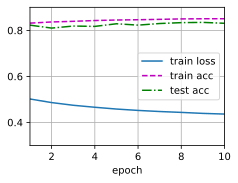

In [28]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)